In [38]:
import sys
import datetime
import pandas as pd
import numpy as np
from graphviz import Digraph
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

In [6]:

data=pd.read_csv(r'C:\Users\kkluc\Python Code\python ML example\chapter7\ad_performance.txt',delimiter='\t')

In [9]:
# 数据审查和校验
print ('{:*^60}'.format('Data overview:'))
print (data.head(2))  # 打印输出前2条数据
print ('{:*^60}'.format('Data dtypes:'))
print (pd.DataFrame(data.dtypes).T)  # 打印数据类型分布
print ('{:*^60}'.format(' NA counts:'))
print (pd.DataFrame(data.isnull().sum()).T)  # 查看缺失值情况
print ('{:*^60}'.format('Data DESC:'))
print (data.describe().round(2).T)  # 打印原始数据基本描述性信息
print ('{:*^60}'.format('Correlation analysis:'))
print (data.corr().round(2).T)  # 打印原始数据相关性信息

***********************Data overview:***********************
   渠道代号    日均UV   平均注册率   平均搜索量    访问深度  平均停留时间   订单转化率  投放总时间 素材类型    广告类型  \
0  A203    3.69  0.0071  0.0214  2.3071  419.77  0.0258   20.0  jpg  banner   
1  A387  178.70  0.0040  0.0324  2.0489  157.94  0.0030   19.0  jpg  banner   

  合作方式    广告尺寸 广告卖点  
0  roi  140*40   打折  
1  cpc  140*40   满减  
************************Data dtypes:************************
     渠道代号     日均UV    平均注册率    平均搜索量     访问深度   平均停留时间    订单转化率    投放总时间  \
0  object  float64  float64  float64  float64  float64  float64  float64   

     素材类型    广告类型    合作方式    广告尺寸    广告卖点  
0  object  object  object  object  object  
************************ NA counts:*************************
   渠道代号  日均UV  平均注册率  平均搜索量  访问深度  平均停留时间  订单转化率  投放总时间  素材类型  广告类型  合作方式  \
0     0     0      0      0     0       2      0      0     0     0     0   

   广告尺寸  广告卖点  
0     0     0  
*************************Data DESC:*************************
        count    mean   

In [10]:
data=data.fillna(data['平均停留时间'].mean())

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 13 columns):
渠道代号      889 non-null object
日均UV      889 non-null float64
平均注册率     889 non-null float64
平均搜索量     889 non-null float64
访问深度      889 non-null float64
平均停留时间    889 non-null float64
订单转化率     889 non-null float64
投放总时间     889 non-null float64
素材类型      889 non-null object
广告类型      889 non-null object
合作方式      889 non-null object
广告尺寸      889 non-null object
广告卖点      889 non-null object
dtypes: float64(7), object(6)
memory usage: 90.4+ KB


In [14]:
data.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20.0,jpg,banner,roi,140*40,打折
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19.0,jpg,banner,cpc,140*40,满减
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4.0,jpg,banner,cpc,140*40,满减
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10.0,jpg,banner,cpc,140*40,满减
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30.0,jpg,banner,cpc,140*40,满减


In [15]:
# 字符串分类转整数分类
# part1
conver_cols = ['素材类型', '广告类型', '合作方式', '广告尺寸', '广告卖点']
convert_matrix = data[conver_cols]  # 获得要转换的数组
lines = data.shape[0]  # 获得总记录数
dict_list = []  # 总空列表，用于存放字符串与对应索引组成的字典
unique_list = []  # 总唯一值列表，用于存储每个列的唯一值列表

# part2
for col_name in conver_cols:  # 循环读取每个列名
    cols_unqiue_value = data[col_name].unique().tolist()  # 获取列的唯一值列表
    unique_list.append(cols_unqiue_value)  # 将唯一值列表追加到总列表
print(unique_list)

[['jpg', 'swf', 'gif', 'sp'], ['banner', 'tips', '不确定', '横幅', '通栏', '暂停'], ['roi', 'cpc', 'cpm', 'cpd'], ['140*40', '308*388', '450*300', '600*90', '480*360', '960*126', '900*120', '390*270'], ['打折', '满减', '满赠', '秒杀', '直降', '满返']]


In [18]:
# part3
for line_index in range(lines):  # 读取每行索引
    each_record = convert_matrix.iloc[line_index]  # 获得每行数据，是一个Series
    
    for each_index, each_data in enumerate(each_record):  # 读取Series每行对应的索引值
        list_value = unique_list[each_index]  # 读取该行索引对应到总唯一值列表列索引下的数据(其实是相当于原来的列做了转置成了行，目的是查找唯一值在列表中的位置)
        each_record[each_index] = list_value.index(each_data)  # 获得每个值对应到总唯一值列表中的索引
    each_dict = dict(zip(conver_cols, each_record))  # 将每个值和对应的索引组合字典
    dict_list.append(each_dict)  # 将字典追加到总列表

In [22]:
# part4 #DictVectorizer使用字典储存的数据进行特征提取与向量化
model_dvtransform = DictVectorizer(sparse=False, dtype=np.int64)  # 建立转换模型对象
data_dictvec = model_dvtransform.fit_transform(dict_list)  # 应用分类转换训练

In [27]:
# 数据标准化
sacle_matrix = data.iloc[:, 1:8]  # 获得要转换的矩阵
minmax_scaler = MinMaxScaler()  # 建立MinMaxScaler模型对象
data_scaled = minmax_scaler.fit_transform(sacle_matrix)  # MinMaxScaler标准化处理

In [28]:
# 合并所有输入维度
X = np.hstack((data_scaled, data_dictvec))

In [31]:
score_list = list()  # 用来存储每个K下模型的平局轮廓系数
silhouette_int = -1  # 初始化的平均轮廓系数阀值
for n_clusters in range(2, 10):  # 遍历从2到10几个有限组
    model_kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # 建立聚类模型对象
    cluster_labels_tmp = model_kmeans.fit_predict(X)  # 训练聚类模型
    silhouette_tmp = metrics.silhouette_score(X, cluster_labels_tmp)  # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:  # 如果平均轮廓系数更高
        best_k = n_clusters  # 将最好的K存储下来
        silhouette_int = silhouette_tmp  # 将最好的平均轮廓得分存储下来
        best_kmeans = model_kmeans  # 将最好的模型存储下来
        cluster_labels_k = cluster_labels_tmp  # 将最好的聚类标签存储下来
    score_list.append([n_clusters, silhouette_tmp])  # 将每次K及其得分追加到列表
print ('{:*^60}'.format('K value and silhouette summary:'))
print (np.array(score_list))  # 打印输出所有K下的详细得分
print ('Best K is:{0} with average silhouette of {1}'.format(best_k, silhouette_int.round(4)))


**************K value and silhouette summary:***************
[[2.         0.46692821]
 [3.         0.54904646]
 [4.         0.56968547]
 [5.         0.48186604]
 [6.         0.45477667]
 [7.         0.48204261]
 [8.         0.50447223]
 [9.         0.52697493]]
Best K is:4 with average silhouette of 0.5697


In [36]:
# 针对聚类结果的特征分析
# part1
cluster_labels = pd.DataFrame(cluster_labels_k, columns=['clusters'])  # 获得训练集下的标签信息
merge_data = pd.concat((data, cluster_labels), axis=1)  # 将原始处理过的数据跟聚类标签整合
# part2
clustering_count = pd.DataFrame(merge_data['渠道代号'].groupby(merge_data['clusters']).count()).T.rename(
    {'渠道代号': 'counts'})  # 计算每个聚类类别的样本量
clustering_ratio = (clustering_count / len(merge_data)).round(2).rename({'counts': 'percentage'})  # 计算每个聚类类别的样本量占比
# part3
cluster_features = []  # 空列表，用于存储最终合并后的所有特征信息
for line in range(best_k):  # 读取每个类索引
    label_data = merge_data[merge_data['clusters'] == line]  # 获得特定类的数据

    part1_data = label_data.ix[:, 1:8]  # 获得数值型数据特征
    part1_desc = part1_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part1_desc.ix[2, :]  # 得到数值型特征的均值
    
    part2_data = label_data.ix[:, 8:-1]  # 获得字符串型数据特征
    part2_desc = part2_data.describe(include='all')  # 获得字符串型数据特征的描述性统计信息
    merge_data2 = part2_desc.ix[2, :]  # 获得字符串型数据特征的最频繁值

    merge_line = pd.concat((merge_data1, merge_data2), axis=0)  # 将数值型和字符串型典型特征沿行合并
    cluster_features.append(merge_line)  # 将每个类别下的数据特征追加到列表
# part4
cluster_pd = pd.DataFrame(cluster_features).T  # 将列表转化为矩阵
print ('{:*^60}'.format('Detailed features for all clusters:'))
all_cluster_set = pd.concat((clustering_count, clustering_ratio, cluster_pd), axis=0)  # 将每个聚类类别的所有信息合并
print (all_cluster_set)

************Detailed features for all clusters:*************
clusters          0        1        2        3
counts          411      297       27      154
percentage     0.46     0.33     0.03     0.17
日均UV        1369.81  1194.69  1263.03   2718.7
平均注册率         0.003    0.003    0.003    0.005
平均搜索量         0.082    0.144    0.151    0.051
访问深度          0.918    5.728      9.8    0.948
平均停留时间      165.094  285.992  374.689   104.14
订单转化率         0.009    0.016    0.017    0.007
投放总时间         8.462     8.57    7.996    8.569
素材类型            swf      jpg      swf      jpg
广告类型            不确定      不确定       通栏   banner
合作方式            cpc      cpc      cpc      cpc
广告尺寸         600*90   600*90  900*120  308*388
广告卖点             打折       直降       打折       满减


C:\Users\kkluc\Anaconda3\Anaconda3 64bit\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\kkluc\Anaconda3\Anaconda3 64bit\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
C:\Users\kkluc\Anaconda3\Anaconda3 64bit\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\kkluc\Anaconda3\Anaconda3 6

C:\Users\kkluc\Anaconda3\Anaconda3 64bit\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


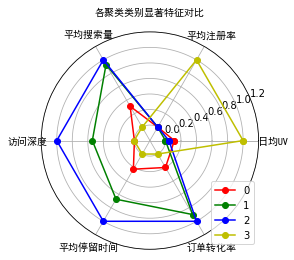

In [39]:

# 各类别显著数值特征对比
# part1
num_sets = cluster_pd.ix[:6, :].T.astype(np.float64)  # 获取要展示的数据
num_sets_max_min = minmax_scaler.fit_transform(num_sets)  # 获得标准化后的数据
# part2
fig = plt.figure()  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index[:-1])  # 设置要展示的数据标签
cor_list = ['r', 'g', 'b', 'y']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
# part3
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
    ax.plot(angles, data, 'o-', c=cor_list[i], label=i)  # 画线
# part4
ax.set_thetagrids(angles * 180 / np.pi, labels, fontproperties="SimHei")  # 设置极坐标轴
ax.set_title("各聚类类别显著特征对比", fontproperties="SimHei")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(loc=0)  # 设置图例位置
plt.show()  # 展示图像
